In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir('..')

pd.set_option('mode.chained_assignment', None)

### 1. Cleaning the survey data

Read in the data with flood depth estimates and reclassify each of the survey responses with a numerical scale. We care most about the columns with location identifiers (shp_id) and flood level (flood_level). We are assuming that the reported flood level corresponds to the maximum flooding experienced by the survey respondent. 

Given that there are many responses for a given mauza, we will also need to get a summary measurement across all responses for a single mauza. Our final dataframe should have one row for each mauza that has at least one survey response (so 643 rows total). 

We will also join the survey data with the mauza shapefile to add in spatial information. 

In [2]:
# Read the csv and select columns of interest
df = pd.read_csv('data/CDP_Survey/household_locations_impactevaluation_matched_floodlevel.csv')
df_sel = df[['shp_id', 'flood_level']]

# How many unique mauzas do we have?
print("Unique mauzas: " + str(len(df_sel.shp_id.unique())))
# Compare this against the total number of responses
print("Total responses: " + str(len(df_sel.shp_id)))

# Create a dict to map flood level to a numerical scale
flood_levels = df_sel.flood_level.unique()
flood_score = {
    flood_levels[0]: 1,
    flood_levels[1]: 2, 
    flood_levels[2]: 3,
    flood_levels[3]: 4,
    flood_levels[4]: 5
}
df_sel['flood_score'] = df['flood_level'].map(flood_score)

# Group by and get the median, mean, standard deviation, and number of responses
df_avg_flood = df_sel.groupby('shp_id').aggregate([np.mean, np.median, np.std, 'count']).reset_index()
df_avg_flood.columns = df_avg_flood.columns.droplevel(0)
df_avg_flood.columns = ['OBJECTID', 'mean', 'median', 'std', 'count']

# Read in shp and join with the data
df_shp = gpd.read_file('data/ADM_Shp/selected_distict_mauza.shp').to_crs('EPSG:32646')
df_flood_shp = df_shp.merge(df_avg_flood, on='OBJECTID', how='right')

Unique mauzas: 643
Total responses: 9130


### 2. Analyse to determine land type

For each mauza with survey data, we want to determine the type of land that it is on: 1) embankment, 2) unprotected char, or 3) unprotected mainland. For mauzas that are spread across two types of land, we want to select the land type that covers the majority of the mauza. 

In [3]:
# Read in the Shapefile that delineates each of these areas
df_emb = gpd.read_file('data/Embankment/protected_embankment.shp').to_crs('EPSG:32646')

# Dissolve to create multipolygons for each type
df_emb = df_emb.dissolve(by='Exposure').reset_index()

# Merge to get distinct polygons 
merged = gpd.overlay(df_flood_shp, df_emb, how='intersection')
merged['area'] = merged.geometry.area

# Now drop duplicate mauzas (by OBJECTID)
# And keep the one with the biggest area
merged = merged.sort_values('area').drop_duplicates('OBJECTID', keep='last')

# Merge back with the original data to get the proper geometry
df_emb_all = df_flood_shp.merge(merged[['Exposure', 'OBJECTID']], on='OBJECTID')

### 3. Join with the satellite-derived flood fraction estimates

We want to compare the reported flood depth from the survey against the maximum flooding estimates derived from Sentinel-1 data. We'll make a set of simple choropleth maps to show the range in distribution across a number of variables to describe the flooding.

In [4]:
# Read in the csv files
df_sent = pd.read_csv('data/FE_Results/MAUZ_flood_extent_sentinel.csv')
df_intp = pd.read_csv('data/FE_Results/MAUZ_flood_summary.csv')

# Merge to keep all of the mauzas in the survey
# Some will have null df_intp data because they did not have any flooding
df_all = df_emb_all.merge(df_intp, left_on='OBJECTID', right_on='PCODE', how='left')

# Check the ones that are null
null = df_all[df_all.FWHM.isnull()]
print(f"{str(len(null.OBJECTID))} mauzas with null satellite-derived data.")

8 mauzas with null satellite-derived data.


In [22]:
# How many mauzas have really high FWHM?
#plt.hist(df_all[df_all.FWHM<200].FWHM)

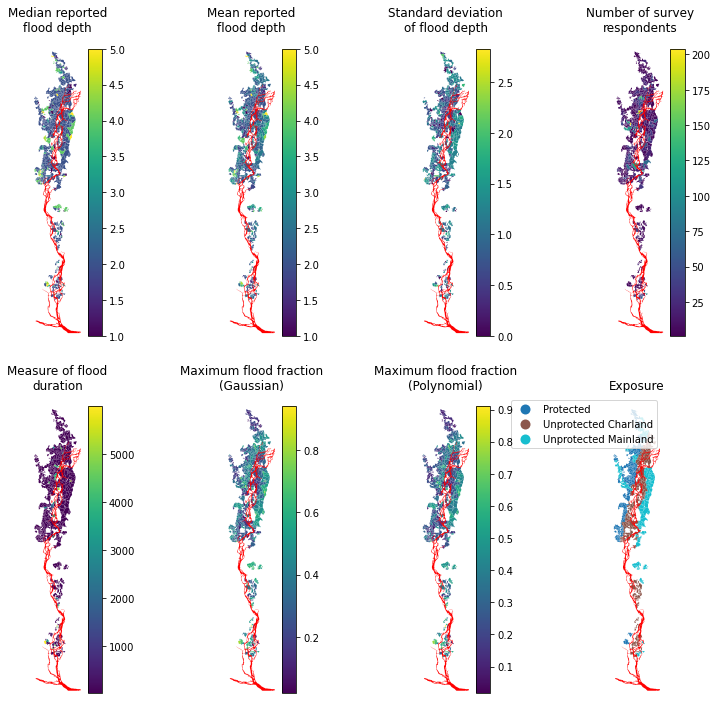

In [13]:
# Read in the Shapefile of the river
shp_jamuna = gpd.read_file('data/GSW_Data/gsw_processes_jamuna_estimate.shp').to_crs('EPSG:32646')

# Make side by side maps of the max flood depth and the max flood extent
# Set up the figures and items to iterate through
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(10, 10))
axes_list = [item for sublist in axes for item in sublist] 
map_list = {'median': 'Median reported\nflood depth',
            'mean': 'Mean reported\nflood depth', 
            'std': 'Standard deviation\nof flood depth', 
            'count': 'Number of survey\nrespondents', 
            'FWHM': 'Measure of flood\nduration', 
            'MAX_G': 'Maximum flood fraction\n(Gaussian)', 
            'MAX_P': 'Maximum flood fraction\n(Polynomial)',
            'Exposure': 'Exposure'}

# Loop through to make the plots
for measure in map_list:
    ax = axes_list.pop(0)
    df_all.plot(column=measure, label=map_list[measure], ax=ax, legend=True)
    shp_jamuna.plot(ax=ax, color='red')
    ax.set_title(map_list[measure])
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_axis_off()

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()
    
plt.tight_layout()
#plt.savefig('results/flood_depth.png', dpi=300)

### 4. Compare measures of flood intensity and severity

We'll create some basic scatterplots to identify potential agreement between the 1) mean reported flood depth, 2) median reported flood depth, 3) max satellite-derived polynomial fitted flooding, 4) max satellite-derived Gaussian fitted flooding, and 5) full-width at half-max.

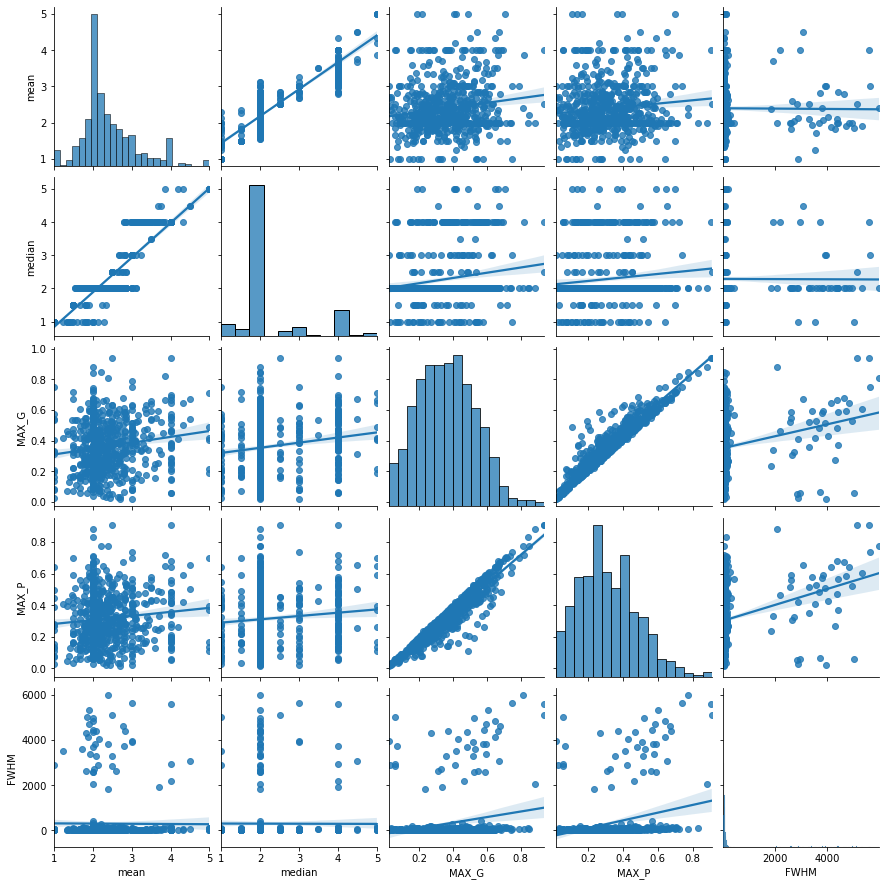

In [6]:
df_plot = df_all[['mean', 'median', 'MAX_G', 'MAX_P', 'FWHM']]
g = sns.pairplot(df_plot, kind='reg')

### 5. Basic output

At this stage, join the survey data with the embankment results and make a simple figure to demonstrate the results.

In [7]:
df_output = df.merge(df_all[['OBJECTID', 'Exposure']], on='OBJECTID', how='left')
df_output.to_csv('data/CDP_Survey/survey_w_exposure.csv')

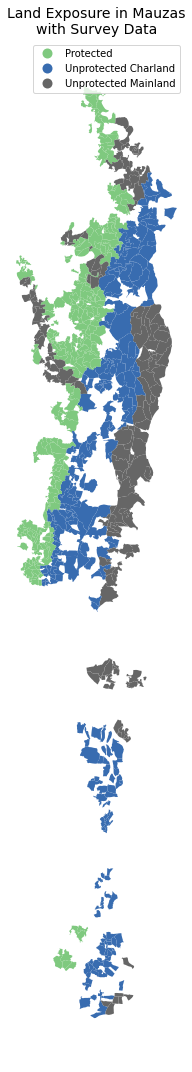

In [8]:
fig, ax = plt.subplots(1, figsize=(10,15))
df_all.plot(column='Exposure', categorical=True, cmap='Accent', linewidth=.4, 
         legend=True
            , ax=ax)
ax.axis('off')
ax.set_title('Land Exposure in Mauzas\nwith Survey Data',fontsize=14)
plt.tight_layout()
plt.savefig('results/Exposure.png')